## Introduction

The Breakthrough Listen instrument at the Green Bank Telescope (GBT) is a digital spectrometer, which takes incoming raw data from the telescope (amounting to hundreds of TB per day) and performs a Fourier Transform to generate a spectrogram. These spectrograms, also referred to as filterbank files, or dynamic spectra, consist of measurements of signal intensity as a function of frequency and time.
Using these spectrograms, we need to identify anomalous signals in scans of Breakthrough Listen targets.

## Light EDA
Let's import all the libraries we need:

In [1]:
import utils
from learning_rate_range_test import LRTest, run_LR_tests
from trainer import Trainer
from engine import predict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


     |████████████████████████████████| 376 kB 597 kB/s eta 0:00:01


In [2]:
# Reproducibility
seed         = 55
random_state = utils.set_seed(seed)

Let's load the data:

In [3]:
train_dir = '/kaggle/input/seti-breakthrough-listen/train/'
test_dir  = '/kaggle/input/seti-breakthrough-listen/test/'
df        = pd.read_csv('/kaggle/input/seti-breakthrough-listen/train_labels.csv')

# Make one column for the filepath
df['path'] = train_dir + df['id'].str[0] + '/' + df['id'] + '.npy'

print(f"No. positive class: {np.sum(df['target'] == 1)}")
print(f"No. negative class: {np.sum(df['target'] == 0)}")

No. positive class: 6000
No. negative class: 54000


Approximately 90% to 10% ratio for class imbalance. Let's setup the resampling strategy:

In [4]:
no_CV_folds = 5

# Stratified CV
skf      = StratifiedKFold(n_splits = no_CV_folds, shuffle = True, random_state = random_state)
skf      = list(skf.split(df['id'], df['target']))

Let's have a look at a couple of files:

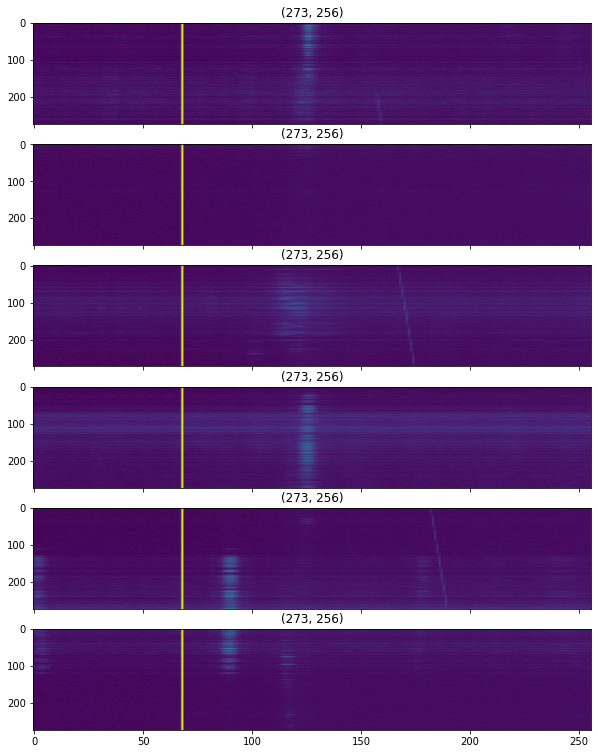

In [6]:
utils.plot_file(df[df['target'] == 1]['path'].iloc[1])

From the competition:

One method we use to isolate candidate technosignatures from RFI is to look for signals that appear to be coming from particular positions on the sky. Typically we do this by alternating observations of our primary target star with observations of three nearby stars: 5 minutes on star “A”, then 5 minutes on star “B”, then back to star “A” for 5 minutes, then “C”, then back to “A”, then finishing with 5 minutes on star “D”. One set of six observations (ABACAD) is referred to as a “cadence”. Since we’re just giving you a small range of frequencies for each cadence, we refer to the datasets you’ll be analyzing as “cadence snippets”.

Not all of the “needle” signals look like diagonal lines, and they may not be present for the entirety of all three “A” observations, but what they do have in common is that they are only present in some or all of the “A” observations (panels 1, 3, and 5 in the cadence snippets).

So, we can take advantage of the fact that we expect the needles to appear in *some* of panels 1, 3, 5. We can train only one those panels, essentially cutting the dataset size by half



## Dataset Transformations

Let's make a dict here to quickly change the transformations on the fly:

In [16]:
transformations = {
    'val_RES': lambda H, W: A.Compose([A.Resize(height = H, width = W, interpolation = 1, p = 1), ToTensorV2()]),
    'val_plain' : ToTensorV2(),
    'train_HVF_SSR_RES' : lambda H, W: A.Compose([A.HorizontalFlip(p = 0.5), 
                              A.VerticalFlip(p = 0.5),
                              A.ShiftScaleRotate(shift_limit = 0.1, scale_limit = 0.1, rotate_limit = 10, p = 0.5),
                              A.Resize(height = H, width = W, interpolation = 1, p = 1),
                              ToTensorV2()]),
    'train_HVF_SSR' : A.Compose([A.HorizontalFlip(p = 0.5), 
                                 A.VerticalFlip(p = 0.5),
                                 A.ShiftScaleRotate(shift_limit = 0.1, scale_limit = 0.1, rotate_limit = 10, p = 0.5),
                                 ToTensorV2()]),
 'train_plain'  : ToTensorV2()
}

## Training

In the following, given the configuration dictionary defined below, we'll be using all the classes defined above, to perform a learning rate range test where needed, along with the learning phase.

First let's define the configuration dict:

In [17]:
config = dict(
    no_epochs       = 10,
    early_stop      = False, # Enable early stopping (True / False)
    patience        = 3,     # Max. epochs to enable early stopping
    min_delta       = 0.005, # Dloss to increment early stopping counter
    batch_size      = 32,
    mdl_base        = 'efficientnet_b1', # Baseline model
    mdl_pretrain    = True,
    mdl_freeze      = False, # Freeze model backbone
    mixup_A         = None,   # Alpha coefficient for mixup (set to None to de-activate)
    spatial_in      = True,  # Train spatial-wise or channel-wise
    AOnly           = True,  # Use entire cadence or the A observations only
    learn_rate      = 6e-4,  # Max. learning rate to be used
    weight_decay    = 1e-2,
    scheduler       = 'OneCycle',
    train_transform = transformations['train_HVF_SSR_RES'](512, 512),
    val_transform   = transformations['val_RES'](512, 512),
    exp_name        = 'Enetb1_Spatial_AOnly_HVF_SSR_RES_512_512_1CycleLR_6e4_1e4_WD1e2_pct_01',
    load_checkpoint = None, # Whether to load everything from a checkpoint
    amp_enable      = True, # Enable AMP
    div_factor      = 6,
    pct_start       = 0.1
)

Let's perform a learning rate range test, to identify a working range for this configuration:

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth
 96%|█████████▌| 96/100 [02:33<00:06,  1.60s/it, loss=6.41e-6]

Diverged on iteration 96 with loss 2.6484375



 96%|█████████▌| 96/100 [02:33<00:06,  1.60s/it, loss=0]    

Diverged on iteration 96 with loss 8.078125


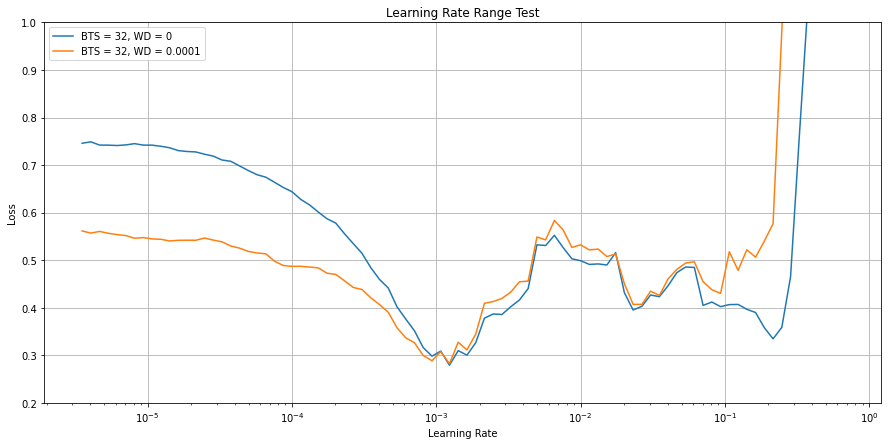

In [18]:
batch_sizes = [32]
w_decays    = [0, 1e-4]
lr_test_res = run_LR_tests(df, skf, config, batch_sizes, w_decays)

LRTest.plot_LR_test(lr_test_res, rolling_window = 10, figsize = (15, 7)); # Plot
plt.ylim([0.2, 1]);
plt.savefig(config['exp_name'] + '_lr_test.png')

And now we can train the ANN:

In [ ]:
T = Trainer(df, skf, save = True)
for fold in range(no_CV_folds): T(config, fold = fold)

Perfect. Now, we can make our predictions with the models we trained earlier. Due to time and GPU limitations, only 3 configurations were utilised, each trained for 5 folds for 10 epochs.

In [ ]:
enet_b1_dir = '/kaggle/input/enet-b1-spatial-mixup-01-512/'

# Read submission template
submission         = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')
submission['path'] = submission['id'].apply(lambda x:f'../input/seti-breakthrough-listen/test/{x[0]}/{x}.npy')

# Predict
outs   = predict(enet_b1_dir, config, submission, no_CV_folds = no_CV_folds)

Perfect. Now we can make our submissions:

In [ ]:
# Average predictions from the model in each fold and update dataframe
pred = np.mean(np.array(outs), axis = 0)
submission.target  = pred
submission['path'] = submission['id'].apply(lambda x:f'../input/seti-breakthrough-listen/test/{x[0]}/{x}.npy')
submission.drop(['path'], axis = 1, inplace = True)
submission.to_csv('submission_b1_no_mixup.csv', index = False)
submission.head()

All three configurations give an average CV score (ROC-AUC) of around 0.85, with a 0.757 score on the leaderboard.
## Model Stacking
Let's see if the use of a meta-model can help a bit:

### Read out-of-fold predictions
Let's read the the OOF predictions of each ANN that will make up the level-1 dataset:

In [19]:
oof_dir = '/kaggle/input/setioofpredictions/'
oof_data = []
sig      = nn.Sigmoid()

for fold in range(no_CV_folds):
    _, val_idx     = skf[fold] # Grab validation set for this fold
    read_substring = 'fold_' + str(fold)
    fold_data      = np.empty((val_idx.shape[0], 4)) # Empty array to hold results for this fold
    fold_data[:]   = np.nan # Fill with nan
    
    fold_data[:,0] = df['target'].iloc[val_idx] # Column 0: Actual target
    mdl_idx = 1 # Counter for model predictions (Columns 1-4)
    
    # Read data
    for _,_,files in os.walk(oof_dir):
        for file in sorted(files):
            if read_substring in file:
                preds = np.load(oof_dir + file) # Load file
                preds = torch.from_numpy(preds) # Convert to tensor
                preds = sig(preds)              # Apply sigmoid
                preds = preds.numpy()           # Convert to numpy
                fold_data[:, mdl_idx] = preds   # Add to matrix
                mdl_idx += 1                    # Increment model (column) counter
    # Append targets and predictions to list
    oof_data.append(fold_data)

oof_data = np.vstack(oof_data)

### Logistic Regression

We'll use a simple logistic regressor as our meta model, trained with the OOF predictions of the 3 ANNs we built earlier, using a 5-fold CV resampling strategy for hyperparameter tuning:

In [20]:
# define dataset
X = oof_data[:, 1:]
y = oof_data[:, 0]

# Define resampling strategy
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)

# define / run grid search
grid_search = GridSearchCV(estimator   = LogisticRegression(), 
                           param_grid  = dict(C = np.logspace(np.log10(100), np.log10(1e-2), 50)), 
                           n_jobs      = -1, 
                           cv          = cv,
                           scoring     = 'roc_auc',
                           error_score = 0)

grid_result = grid_search.fit(X, y)
    
# Grab & print results
best_idx    = grid_result.best_index_
best_score  = grid_result.cv_results_['mean_test_score'][best_idx]
best_std    = grid_result.cv_results_['std_test_score'][best_idx]
best_params = grid_result.best_params_

# summarize results
print("Best: %f +- %f using %s" % (best_score, best_std, best_params))

Best: 0.863723 +- 0.006017 using {'C': 0.24420530945486524}


## Submission

Perfect. Now, we can read the predictions of the ANNs built earlier, and make our final predictions with the meta model:

In [ ]:
# Read submission files
def read_submissions(submission_dir):
    
    files = os.listdir(submission_dir)
    dfs   = []

    for idx, file in enumerate(files):
        df = pd.read_csv(submission_dir + file, index_col = 0)
        df.columns = ['pred_' + str(idx)]
        dfs.append(df)
    
    df = pd.concat(dfs, axis = 1)
    
    return df

df = read_submissions('/kaggle/input/seti-submissions/')
mdl = LogisticRegression(C = 0.244205)
mdl.fit(X, y)
df['target'] = mdl.predict_proba(df.values)[:, 1]
df.drop(['pred_0', 'pred_1', 'pred_2'], axis = 1, inplace = True)
df.to_csv('LR_1_submission.csv', index = True)

Indeed, the meta-model increased the LB score to 0.759. If there were not any time (or compute) limitations, the ANNs could have been trained for a higher number of epochs, and more configurations would have been tested.
Nevertheless, a top 20% score was obtained, even though only 3 configurations were tested, each trained for 10 epochs only.